In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install netCDF4

from matplotlib import pyplot as plt
from netCDF4 import Dataset
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np

datathon = Path('drive/My Drive/colab/hida-datathon')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 4.1MB 2.8MB/s 
     |████████████████████████████████| 337kB 50.0MB/s 


Integrated from [HIDA Datathon](https://github.com/HIDA-Datathon/Climate_Model_Data/blob/master/common.py) and [netCDF_simon](https://github.com/timohouben/hida-datathon-ufz/blob/master/netCDF_simon.ipynb)

In [0]:
def get_solar_data():
    data = Dataset(datathon / 'data/Solar_forcing_1st_mill.nc', 'r', format='NETCDF4')
    t = data.variables['time'][:]
    TSI = data.variables['TSI'][:, 0, 0]
    data.close()
    return t, TSI


def get_volcanic_data():
    data = Dataset(datathon / 'data/Volc_Forc_AOD_1st_mill.nc', 'r', format='NETCDF4')
    t = data.variables['time'][:]
    AOD = data.variables['AOD'][:, 0, 0]
    data.close()
    return t, AOD


def get_geodata(number):
    filename = 'data/T2m_R{}_ym_1stMill.nc'.format(number)
    data = Dataset(datathon / filename, 'r', format='NETCDF4')
    t = data.variables['time'][:]
    lon = data.variables['lon'][:]
    lat = data.variables['lat'][:]
    T2m = data.variables['T2m'][:, :, :]
    data.close()
    return t, lon, lat, T2m


def plot_forcing():
    t, TSI = get_solar_data()
    t, AOD = get_volcanic_data()

    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, TSI)
    plt.subplot(2, 1, 2)
    plt.plot(t, AOD)


def plot_geodata(t_index, data):
    plt.figure()
    plt.imshow(data[t_index, :, :], cmap='jet')

In [0]:
# a latitude threshold to split data into zones, ~23 degrees
zone_threshold = 23.43666

In [0]:
# t2m is of size (999, 96, 192), [time, lat, lon] 
t_geo, lon, lat, t2m = get_geodata(1)
t_solar, tsi = get_solar_data()
t_vulcanic, aod = get_volcanic_data()

In [11]:
# constant threshold to detect erruptions
threshold = .01
erruptions = []
erruption = False

for idx, val in enumerate((aod > threshold).astype(int)):
  if (val == 1) and not erruption:
    erruption = True
    start = idx
    acc = 1
  elif (val == 0) and erruption:
    erruptions.append((start, acc))
    erruption = False
  elif (val == 1) and erruption:
    acc += 1


print("How many erruptions?", len(erruptions))
print("When did they happen?")
erruption_slices = []
window_size = 5
for idx, (start, length) in enumerate(erruptions):
  print(idx+1, start, ":", start + window_size, length)
  erruption_slices.append(slice(start, start + window_size))

How many erruptions? 22
When did they happen?
1 162 : 167 5
2 212 : 217 3
3 231 : 236 3
4 260 : 265 5
5 297 : 302 4
6 336 : 341 3
7 352 : 357 2
8 385 : 390 3
9 425 : 430 5
10 527 : 532 8
11 564 : 569 5
12 579 : 584 2
13 673 : 678 7
14 689 : 694 2
15 740 : 745 5
16 746 : 751 4
17 810 : 815 5
18 852 : 857 2
19 895 : 900 1
20 912 : 917 4
21 924 : 929 3
22 971 : 976 4


In [31]:
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from functools import reduce 

def flatten(X):
  # we need to reduce dimensions (948, 5, 96, 192) (46, 5, 96, 192)
  return np.mean(np.mean(X, 3), 2)

def in_slice(x, slice_):
  return x >= slice_.start and x < slice_.stop

def is_erruption(start, slices):
  return (np.logical_or.reduce(list(map(lambda x: in_slice(start, x), slices)))
  or np.logical_or.reduce(list(map(lambda x: in_slice(start+window_size, x), slices))))


# as long as we are not using model selection or hyperparameter tuning,
# we don't really need the validation set

# out of 22 erruption cases, we choose 5 for testing, the rest is for training
test_slices = slice(14, 19)

X_train, X_test, y_train, y_test = [], [], [], []
for i in range(t2m.shape[0] - window_size):
  if not is_erruption(i, erruption_slices[test_slices]):
    X_train.append(t2m[i:i+window_size])
    y_train.append(1 if is_erruption(i, erruption_slices) else 0)
  else:
    X_test.append(t2m[i:i+window_size])
    y_test.append(1 if is_erruption(i, erruption_slices) else 0)

for i in np.arange(0, 100, 20):
    X_test.append(t2m[i:i+window_size])
    y_test.append(0)
  
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

pipeline = Pipeline(steps=[
  ('flatten_features', FunctionTransformer(flatten)),
  ('learner', SVC(kernel="rbf"))
])

clf = pipeline.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = auc(y_test, y_pred)
print(score)

# To check, where exactly the difficult part is,
# we can also print a confusion matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TP: {:>3}, TN: {:>3}, FP: {:>3}, FN: {:>3}".format(tp, tn, fp, fn))

(948, 5, 96, 192) (51, 5, 96, 192) (948,) (51,)
0.6739130434782609
TP:  16, TN:   5, FP:   0, FN:  30


In [0]:
def to_zone(x):
  return "N" if x >= zone_threshold else "M" if x > -1 * zone_threshold else "S"


zones = np.array(list(map(to_zone, lat)))
zones

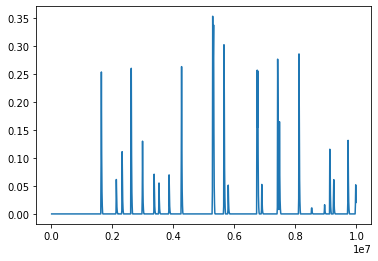

In [0]:
%matplotlib inline

plt.plot(t_vulcanic, aod)
plt.show()

In [0]:
def binning2D(df, agg_fn=np.mean, lat_bins=30, lon_bins=10):
  # dataframe with attributes lat, lon, time, T2m
  # lon = [0, 360]
  # lat = [-90, 90]
  lat_bin_size, lon_bin_size = 180. / lat_bins, 360. / lon_bins
  df['lat_bin'] = (df['lat'] + 90) // lat_bin_size
  df['lon_bin'] = df['lon'] // lon_bin_size
  df.groupby(['time', 'lat_bin', 'lon_bin']).agg({'T2m': agg_fn})
  return df[['time', 'lat_bin', 'lon_bin', 'T2m']]

df = xr.open_dataset(datathon / 'data/T2m_R1_ym_1stMill.nc').to_dataframe()
binning2D(df.reset_index())

NameError: ignored